# Lecture 22 - Vision Languge Models

```{contents}
:local:
:depth: 1
```

## Learning goals
- Understand the core idea of **CLIP**: aligning image and text representations with a contrastive loss.
- Build a tiny **zero-shot classifier** for crystal images and compute simple metrics.
- Train a small **linear probe** on top of frozen CLIP embeddings.
- Visualize **embedding structure** with PCA and t-SNE.
- Start a **vision chat** with a GPT model using the Responses API.

 [![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1ihq56j_5Khl2PY1pDqUlTb1QDu2Uf1Ck?usp=sharing) 



## 1. Setup

In [1]:
# pip installs are kept separate so you can see which step fails.
import os
os.environ["TQDM_DISABLE"] = "1"


try:
    import torch, torchvision, PIL, sklearn, matplotlib, numpy  # quick smoke test
except Exception as e:
    print("Installing required packages...")
#     %pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cpu
#     %pip -q install ftfy regex tqdm onnxruntime matplotlib scikit-learn pillow einops requests

# Install CLIP from the official repository
try:
    import clip  # noqa
except Exception:
    %pip -q install git+https://github.com/openai/CLIP.git

from openai import OpenAI  # noqa

#     %pip -q install openai>=1.40.0
# 0.2 Imports and basic config
import os, json, math, random, io, textwrap, time, pathlib, itertools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import requests
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from openai import OpenAI
from io import BytesIO

import clip  # OpenAI CLIP
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


## 2. CLIP: Connecting Text and Images

CLIP learns two encoders:
1. an **image encoder** $f_{\theta}(\cdot)$
2. a **text encoder** $g_{\phi}(\cdot)$

Each image–text pair in a batch is projected into a common space. Similar pairs should have **high cosine similarity**, mismatched pairs should be low.


We scale cosine similarities by a learnable temperature $\tau$ and use a symmetric cross entropy.
For a batch of size $N$ with normalized embeddings
$U = \{u_i\}$ for images and $V = \{v_i\}$ for texts,

$
s_{ij} = \frac{u_i^\top v_j}{\tau}
$

The loss is:
$
\mathcal{L} = \frac{1}{2}
\left[
  \frac{1}{N}\sum_{i=1}^N -\log \frac{e^{s_{ii}}}{\sum_{j=1}^N e^{s_{ij}}}
  +
  \frac{1}{N}\sum_{i=1}^N -\log \frac{e^{s_{ii}}}{\sum_{j=1}^N e^{s_{ji}}}
\right]
$


In plain words, matching image–text pairs get pushed together and everything else gets pushed apart.
This simple recipe is very effective for **zero-shot** use.

We start with a small ViT model to keep memory use friendly.

In [2]:
model_name = "ViT-B/32"
model, preprocess = clip.load(model_name, device=device, jit=False)
model.eval()
print(type(model))
#print(preprocess)  

<class 'clip.model.CLIP'>


The `preprocess` transform will resize, center-crop, and normalize images. We apply it before encoding.

In [3]:
# Peek at text tokenizer behavior
tokens = clip.tokenize(["a microscopy image of a crystal", "a photo of a dog"]).to(device)
print("Token tensor shape:", tokens.shape)
print(tokens[0, :10])

Token tensor shape: torch.Size([2, 77])
tensor([49406,   320, 38431,  2867,   539,   320,  6517, 49407,     0,     0],
       dtype=torch.int32)


Now, let's bring in crystal images from a GitHub folder.

We will use the same dataset from the last lecture.

Folder (GitHub API): https://api.github.com/repos/zzhenglab/ai4chem/contents/book/_data?ref=main
Labels: ['crystal', 'nocrystal']


Images loaded: 240


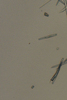

,name,label,url,width,height
0,crystal_test10_tile0_rot0.png,crystal,https://raw.githubusercontent.com/zzhenglab/ai...,67,100
1,crystal_test10_tile0_rot180.png,crystal,https://raw.githubusercontent.com/zzhenglab/ai...,67,100
2,crystal_test10_tile0_rot90.png,crystal,https://raw.githubusercontent.com/zzhenglab/ai...,100,67
3,crystal_test10_tile1_rot0.png,crystal,https://raw.githubusercontent.com/zzhenglab/ai...,67,100
4,crystal_test10_tile1_rot180.png,crystal,https://raw.githubusercontent.com/zzhenglab/ai...,67,100


In [4]:
GITHUB_DIR_API = "https://api.github.com/repos/zzhenglab/ai4chem/contents/book/_data?ref=main"

# Labels are determined from filename prefixes.
# Images whose names start with "crystal_" will be labeled "crystal",
# and those starting with "nocrystal_" will be labeled "nocrystal".
LABELS = ["crystal", "nocrystal"]

print("Folder (GitHub API):", GITHUB_DIR_API)
print("Labels:", LABELS)

def fetch_image(url: str):
    """
    Downloads an image from the given URL and returns it as a Pillow Image object.
    Converts the image to RGB format for consistency.
    If the download or decoding fails, returns None instead of crashing.
    """
    try:
        r = requests.get(url, timeout=10)   # Fetch the image file from GitHub
        r.raise_for_status()                # Raise an error for bad responses (e.g., 404)
        return Image.open(io.BytesIO(r.content)).convert("RGB")  # Convert bytes to image
    except Exception as e:
        print("Skip:", url, "|", e)         # Log and skip any problematic file
        return None

def list_relevant_files():
    """
    Queries the GitHub folder for all files and filters them to include only
    PNG images whose filenames start with 'crystal_' or 'nocrystal_'.
    Returns a list of dictionaries containing filenames and direct download URLs.
    """
    r = requests.get(GITHUB_DIR_API, timeout=15)  # Get folder contents from GitHub API
    r.raise_for_status()
    items = r.json()                              # Parse JSON response into Python objects
    wanted = []
    for it in items:
        if it.get("type") != "file":              # Skip subfolders or non-file items
            continue
        name = it.get("name", "")
        if not name.lower().endswith(".png"):     # Skip non-PNG files
            continue
        low = name.lower()
        if low.startswith("crystal_") or low.startswith("nocrystal_"):
            # If file name matches one of the two prefixes, save it
            url = it.get("download_url")          # Direct link to the raw file
            if url:
                wanted.append({"name": name, "url": url})
    return wanted

def make_dataset():
    """
    Builds a dataset by downloading all relevant PNG files,
    assigning each a label based on its filename prefix,
    and storing both the image and its metadata.
    Returns a list of records (dicts).
    """
    records = []
    for f in list_relevant_files():
        name = f["name"]
        url = f["url"]
        # Infer the label from the filename prefix
        label = "crystal" if name.lower().startswith("crystal_") else "nocrystal"
        img = fetch_image(url)                  # Download and decode the image
        if img is None:
            continue                            # Skip missing or broken images
        records.append({"label": label, "url": url, "name": name, "pil": img})
    return records

# Build the dataset by fetching and labeling all matching images
dataset = make_dataset()
print("Images loaded:", len(dataset))

# Display one sample image (in Jupyter or similar environment)
if len(dataset) > 0:
    display(dataset[0]["pil"])

# Create a tidy DataFrame summarizing the dataset for later analysis
df = pd.DataFrame(
    {
        "name": [r["name"] for r in dataset],       # filename
        "label": [r["label"] for r in dataset],     # crystal or nocrystal
        "url": [r["url"] for r in dataset],         # direct GitHub URL
        "width": [r["pil"].width for r in dataset], # image width in pixels
        "height": [r["pil"].height for r in dataset]# image height in pixels
    }
)

# Show the first few rows to confirm the data structure
df.head()

Now we will encode images and texts with CLIP.

We compute normalized embeddings for both modalities. Shapes matter a lot, so we print them.

In [5]:
# 4.1 Build a small image batch
image_tensors = []
image_labels = []
image_urls = []
for row in dataset:
    image_tensors.append(preprocess(row["pil"]))
    image_labels.append(row["label"])
    image_urls.append(row["url"])

if len(image_tensors) == 0:
    print("No images in dataset. Please fix paths in CLASS_TO_FILES.")
else:
    image_batch = torch.stack(image_tensors).to(device)
    print("image_batch:", tuple(image_batch.shape), "dtype:", image_batch.dtype)

# 4.2 Build text prompts
class_names = ["crystal", "nocrystal"]

nice_label = {
    "crystal":   "a crystal",
    "nocrystal": "nothing present"
}

templates = [
    "an image showing {label}",
    "a photo of {label} structure",
    "a scientific image of {label}"
]

def build_prompts(class_names, templates, nice_label):
    # Order: for each class i, all templates j  -> matches zero_shot_classify pooling
    prompts = []
    for cname in class_names:
        text_label = nice_label.get(cname, cname)
        for t in templates:
            prompts.append(t.format(label=text_label))
    return prompts

prompts = build_prompts(class_names, templates, nice_label)
tokenized = clip.tokenize(prompts).to(device)
print(f"{len(prompts)} prompts built:", prompts[:4], "...")
print("Number of prompts:", len(prompts), "tokenized:", tuple(tokenized.shape))

# 4.3 Forward through CLIP to get embeddings
if len(image_tensors) > 0:
    with torch.no_grad():
        img_feats = model.encode_image(image_batch)
        txt_feats = model.encode_text(tokenized)

    # Normalize to unit length
    img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
    txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)

    print("img_feats:", tuple(img_feats.shape))
    print("txt_feats:", tuple(txt_feats.shape))

image_batch: (240, 3, 224, 224) dtype: torch.float32
6 prompts built: ['an image showing a crystal', 'a photo of a crystal structure', 'a scientific image of a crystal', 'an image showing nothing present'] ...
Number of prompts: 6 tokenized: (6, 77)


img_feats: (240, 512)
txt_feats: (6, 512)


Below you will see how the image embeddings looks like for images.
We have 240 images and each are 512D.

In [6]:
print("img_feats:", tuple(img_feats.shape))
img_feats

img_feats: (240, 512)


tensor([[-0.0151, -0.0108, -0.0012,  ...,  0.0869,  0.0058, -0.0252],
        [-0.0104, -0.0084,  0.0115,  ...,  0.0837,  0.0092, -0.0207],
        [-0.0093, -0.0091,  0.0074,  ...,  0.0853,  0.0081, -0.0234],
        ...,
        [-0.0083, -0.0009,  0.0182,  ...,  0.0495,  0.0122, -0.0181],
        [-0.0155, -0.0005,  0.0130,  ...,  0.0491,  0.0062, -0.0201],
        [-0.0047, -0.0107,  0.0181,  ...,  0.0521,  0.0176, -0.0201]])

Below you will see how the text embeddings looks like.
We have 8 text embeddings and each are 512D.

In [7]:
print("txt_feats:", tuple(txt_feats.shape))
txt_feats

txt_feats: (6, 512)


tensor([[-0.0068,  0.0512,  0.0147,  ..., -0.0265,  0.0198, -0.0232],
        [-0.0074,  0.0487, -0.0029,  ..., -0.0006, -0.0432, -0.0203],
        [-0.0061,  0.0436,  0.0131,  ...,  0.0141, -0.0021,  0.0008],
        [-0.0028, -0.0146, -0.0155,  ..., -0.0433,  0.0047, -0.0198],
        [ 0.0108, -0.0063, -0.0289,  ..., -0.0393, -0.0305, -0.0033],
        [ 0.0081, -0.0164, -0.0182,  ..., -0.0337,  0.0004,  0.0052]])

What do the embeddings look like?

We reduce dimensionality to 2D so we can plot and inspect cluster structure.
We expect images from the same label to be near each other.

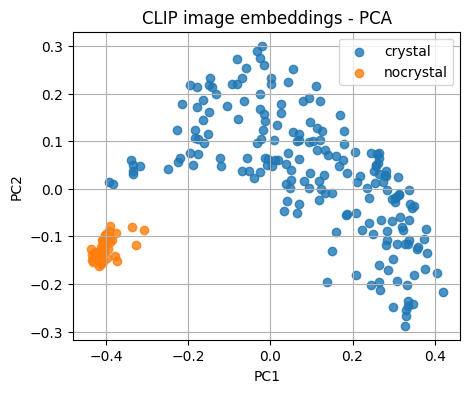

In [8]:
if len(image_tensors) > 0:
    X = img_feats.detach().cpu().numpy()
    pca = PCA(n_components=2, random_state=0)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(5,4))
    for lab in sorted(set(image_labels)):
        idx = [i for i, y in enumerate(image_labels) if y == lab]
        plt.scatter(X_pca[idx,0], X_pca[idx,1], label=lab, alpha=0.8)
    plt.legend()
    plt.title("CLIP image embeddings - PCA")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.grid(True)
    plt.show()
else:
    print("No images to plot")

```{admonition} Note
PCA is linear and fast. t-SNE can separate clusters further but is slower and higher variance.
```

In [9]:
if len(image_tensors) > 0 and len(image_tensors) <= 200:
    tsne = TSNE(n_components=2, random_state=0, perplexity=min(30, len(image_tensors)-1))
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(5,4))
    for lab in sorted(set(image_labels)):
        idx = [i for i, y in enumerate(image_labels) if y == lab]
        plt.scatter(X_tsne[idx,0], X_tsne[idx,1], label=lab, alpha=0.8)
    plt.legend()
    plt.title("CLIP image embeddings - t-SNE")
    plt.xlabel("tSNE-1"); plt.ylabel("tSNE-2")
    plt.grid(True)
    plt.show()

## 3. Prediction based on Embeddings

Before we evaluate performance, we’ll compare each image embedding to the text embeddings created from our prompts.

Both image and text vectors come from the same pretrained model, so we can measure how similar they are using cosine similarity.

Each image is assigned to the class whose text description is most similar to it — no training, just comparison in the shared embedding space.
Then we check how well those predictions match the true labels from our dataset.

In [10]:
def zero_shot_classify(img_feats, txt_feats, class_names, templates, temperature=1.0):
    # Normalize both sets of features so cosine similarity = dot product
    img_z = F.normalize(img_feats, dim=1)            # [N, d] image embeddings
    txt_z = F.normalize(txt_feats, dim=1)            # [C*T, d] text embeddings (C classes × T templates)

    # Group text prompts belonging to each class
    T = len(templates)
    per_class = [list(range(i*T, (i+1)*T)) for i in range(len(class_names))]

    # Compute image–text similarities and average over prompts of the same class
    sims = img_z @ txt_z.t()                         # [N, C*T] cosine similarities
    sims = sims / max(1e-8, temperature)             # optional scaling (lower = sharper differences)
    pooled = torch.stack([sims[:, idxs].mean(dim=1) for idxs in per_class], dim=1)  # [N, C]

    # Take the class with the highest mean similarity as prediction
    preds = pooled.argmax(dim=1).cpu().numpy()
    return preds, pooled.cpu().numpy()

# Run zero-shot classification and evaluate
if len(image_tensors) > 0:
    # Convert string labels in the dataset to numeric indices
    y_true = np.array([class_names.index(r["label"]) for r in dataset])

    # Predict using the zero-shot classifier
    preds, pooled = zero_shot_classify(img_feats, txt_feats, class_names, templates, temperature=0.01)

    # Report accuracy and detailed metrics
    print("Accuracy:", accuracy_score(y_true, preds))
    print(classification_report(y_true, preds, target_names=class_names, digits=3, zero_division=0))

Accuracy: 0.8125
              precision    recall  f1-score   support

     crystal      1.000     0.766     0.867       192
   nocrystal      0.516     1.000     0.681        48

    accuracy                          0.812       240
   macro avg      0.758     0.883     0.774       240
weighted avg      0.903     0.812     0.830       240



Now, we will run linear probe on frozen embeddings.

A simple linear model can be trained quickly on top of CLIP features when you have a few labeled images.

Note: below we only use `img_feats` for the prediction.

In [11]:
if len(image_tensors) > 0:
    # Features and integer labels
    X = img_feats.detach().cpu().numpy()
    y = np.array([class_names.index(c) for c in image_labels])

    # Try a stratified 80:20 split for balanced class representation
    try:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        train_idx, test_idx = next(sss.split(X, y))
    except ValueError:
        # Happens when at least one class has only a single sample
        # Fall back to a plain random 80:20 split without stratify
        train_idx, test_idx = train_test_split(
            np.arange(len(y)), test_size=0.2, random_state=42, shuffle=True
        )

    X_train, y_train = X[train_idx], y[train_idx]
    X_test,  y_test  = X[test_idx],  y[test_idx]

    clf = LogisticRegression(max_iter=200, multi_class="auto")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"Train size: {len(y_train)} | Test size: {len(y_test)}")
    print("Linear probe test accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names, digits=3))

Train size: 192 | Test size: 48
Linear probe test accuracy: 0.9791666666666666
              precision    recall  f1-score   support

     crystal      0.974     1.000     0.987        38
   nocrystal      1.000     0.900     0.947        10

    accuracy                          0.979        48
   macro avg      0.987     0.950     0.967        48
weighted avg      0.980     0.979     0.979        48



C:\Users\52377\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Below shows the confusion matrix and the ROC curve for our test set.

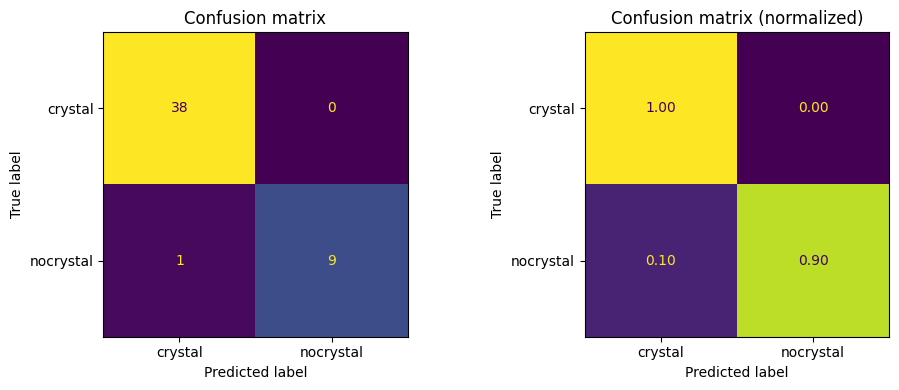

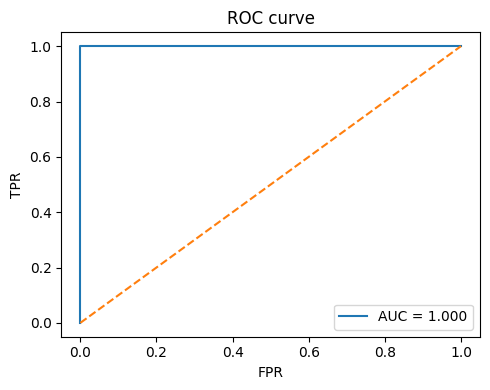

In [12]:
# Confusion matrix (counts and normalized)
cm = confusion_matrix(y_test, y_pred, labels=range(len(class_names)))
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(ax=ax[0], colorbar=False)
ax[0].set_title("Confusion matrix")

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(cm_norm, display_labels=class_names)
disp.plot(ax=ax[1], colorbar=False, values_format=".2f")
ax[1].set_title("Confusion matrix (normalized)")
plt.tight_layout()
plt.show()

# ROC curve for binary case (optional)
if len(class_names) == 2:
    try:
        if hasattr(clf, "decision_function"):
            scores = clf.decision_function(X_test)
        else:
            scores = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, scores, pos_label=class_names.index(class_names[1]))
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0,1], [0,1], linestyle="--")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title("ROC curve")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("ROC skipped:", e)

To better visualize this. First, we prep features, score zero shot, pick up to two correct hits per class, and print quick snapshots of the first 8 dims for image, text, and the simple average merge.

In [13]:
# === Part 1: prep, scoring, picks, and 8-dim snapshots ===
# Idea:
# 1) normalize features for cosine math
# 2) compute zero-shot scores per class (average over templates)
# 3) choose up to 2 correct examples per class
# 4) print a compact peek of the first 8 dims for image, text, and merged

import numpy as np, torch, torch.nn.functional as F
np.set_printoptions(precision=4, suppress=True)

# Repro for any random sampling below
rng = np.random.default_rng(9)

# ----- Normalize features -----
# img_feats: [N, d], txt_feats: [C*T, d]
img_test = img_feats[test_idx] if isinstance(img_feats, torch.Tensor) else torch.tensor(img_feats[test_idx])
img_test_z = F.normalize(img_test, dim=1)  # [N_test, d]

T, C = len(templates), len(class_names)
txt_z_in = txt_feats if isinstance(txt_feats, torch.Tensor) else torch.tensor(txt_feats)
txt_z = F.normalize(txt_z_in, dim=1)       # [C*T, d]

# ----- Zero-shot scores and predictions -----
# sims: pairwise cosine similarities to all prompts
sims = img_test_z @ txt_z.t()  # [N_test, C*T]

# pool templates per class by mean
pooled = torch.stack([sims[:, range(c*T, (c+1)*T)].mean(1) for c in range(C)], 1)
preds = pooled.argmax(1).cpu().numpy()

# ----- Pick up to 2 correct examples per class -----
picks = []
for c in range(C):
    ok = np.where((y_test == c) & (preds == c))[0]
    if len(ok) > 0:
        picks.extend(rng.choice(ok, size=min(2, len(ok)), replace=False).tolist())

# ----- Print 8-dim snapshots -----
print("=== Embedding snapshots (first 8 dims) ===")
for j, loc in enumerate(picks):
    c = int(preds[loc])
    v_img   = img_test_z[loc].cpu().numpy()
    v_text  = txt_z[c*T].cpu().numpy()
    v_merge = F.normalize((img_test_z[loc] + txt_z[c*T]) / 2, dim=0).cpu().numpy()

    # Clear labeling helps when scanning outputs
    print(f"\nExample {j+1} | Label={class_names[c]}")
    print("image :", v_img[:8])
    print("text  :", v_text[:8])
    print("merged:", v_merge[:8])

# Quick sanity display
print(f"\nPicked {len(picks)} examples across {C} classes.")

=== Embedding snapshots (first 8 dims) ===

Example 1 | Label=crystal
image : [-0.0134 -0.0128  0.0425  0.0124  0.0175  0.0037  0.0315  0.012 ]
text  : [-0.0068  0.0512  0.0147 -0.0033  0.0193 -0.0121  0.0157 -0.0576]
merged: [-0.0126  0.024   0.0358  0.0057  0.023  -0.0052  0.0295 -0.0285]

Example 2 | Label=crystal
image : [-0.0222 -0.0058  0.0028 -0.0042  0.0449  0.0043  0.0157  0.0588]
text  : [-0.0068  0.0512  0.0147 -0.0033  0.0193 -0.0121  0.0157 -0.0576]
merged: [-0.018   0.0284  0.011  -0.0047  0.0401 -0.0048  0.0196  0.0008]

Example 3 | Label=nocrystal
image : [-0.0084 -0.0094  0.0046 -0.0284  0.002  -0.0242 -0.031   0.1046]
text  : [-0.0028 -0.0146 -0.0155  0.0167 -0.0004 -0.013   0.0059 -0.0894]
merged: [-0.0071 -0.0152 -0.0069 -0.0074  0.001  -0.0235 -0.0159  0.0096]

Example 4 | Label=nocrystal
image : [-0.0083 -0.0009  0.0182 -0.0269 -0.0008 -0.0051 -0.0447  0.1144]
text  : [-0.0028 -0.0146 -0.0155  0.0167 -0.0004 -0.013   0.0059 -0.0894]
merged: [-0.0071 -0.0099  0.001

between steps, we also want a 2D view to compare spaces with a shared projector. next, we fit PCA on the image-only space, then project the text and merged points with the same transform. to make this cell display something even without plotting, it prints explained variance and a tiny table of projected coords for the chosen examples.

In [14]:
# === Part 2: PCA fit on image space; project text and merged ===
# Plan: fit PCA on image embeddings, then transform text-only and merged pairs
# We also print explained variance and a small table of the 2D coords.

from sklearn.decomposition import PCA

# Fit PCA on image-only space
pca = PCA(n_components=2, random_state=42)
X2_img = pca.fit_transform(img_test_z.cpu().numpy())  # [N_test, 2]

# Project the chosen text and merged vectors using the same PCA
X2_text, X2_merge = [], []
for loc in picks:
    c = int(preds[loc])
    v_text  = txt_z[c*T].cpu().numpy()[None, :]  # shape [1, d]
    v_merge = F.normalize((img_test_z[loc] + txt_z[c*T]) / 2, dim=0).cpu().numpy()[None, :]

    X2_text.append(pca.transform(v_text)[0])
    X2_merge.append(pca.transform(v_merge)[0])

X2_text  = np.array(X2_text)
X2_merge = np.array(X2_merge)

# ----- Display: explained variance and a tiny coordinate table -----
evr = pca.explained_variance_ratio_
print("=== PCA explained variance ratio ===")
print(f"PC1: {evr[0]:.4f}, PC2: {evr[1]:.4f}")

print("\n=== Sample 2D coords for picks ===")
print("idx | label             | text_x   text_y   | merge_x  merge_y")
for (tx, ty), (mx, my), loc in zip(X2_text, X2_merge, picks):
    lab = class_names[int(y_test[loc])]
    print(f"{loc:3d} | {lab:<16} | {tx:7.3f} {ty:7.3f} | {mx:7.3f} {my:7.3f}")

=== PCA explained variance ratio ===
PC1: 0.5070, PC2: 0.1180

=== Sample 2D coords for picks ===
idx | label             | text_x   text_y   | merge_x  merge_y
 14 | crystal          |   0.064  -0.115 |   0.301  -0.141
 42 | crystal          |   0.064  -0.115 |   0.028   0.071
 19 | nocrystal        |  -0.034  -0.093 |  -0.273  -0.104
 10 | nocrystal        |  -0.034  -0.093 |  -0.274  -0.113


Finally, the side by side figure. Left is the image cloud with thumbnails for the chosen points. Middle places the projected text points. Right shows the merged points.

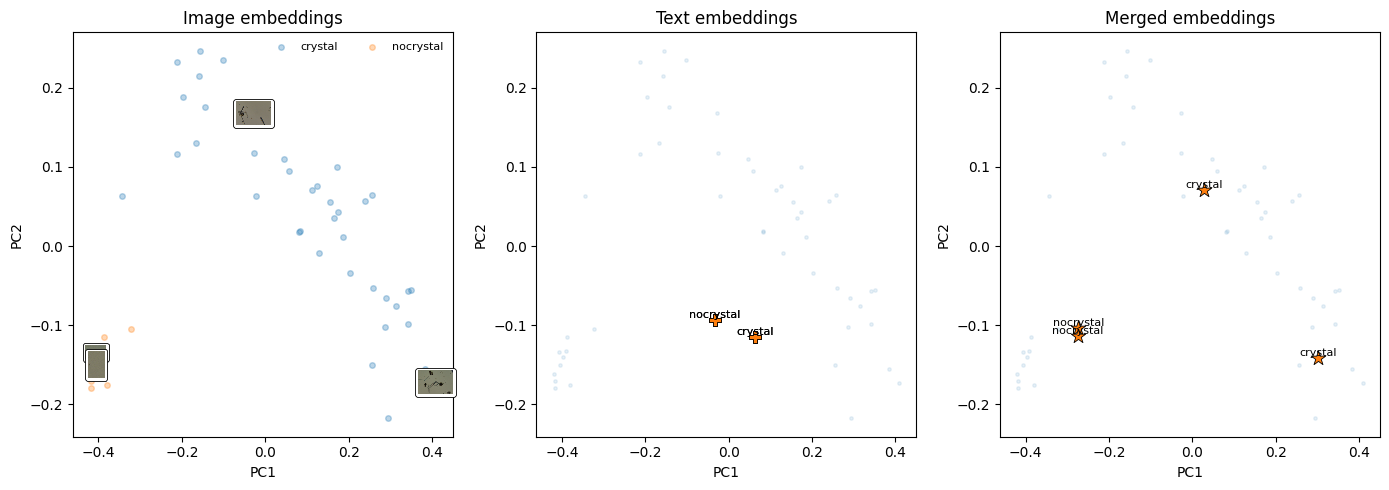

In [15]:
# === Part 3: 3-panel plot: image-only, text-only, merged ===
# Notes:
# - left: image embeddings with per-class scatter and thumbnails for picks
# - middle: text points for the picks
# - right: merged (image + predicted-class text) for the picks

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# ----- Panel 1: image-only with thumbnails -----
ax = axes[0]
for c, name in enumerate(class_names):
    pts = X2_img[y_test == c]
    ax.scatter(pts[:, 0], pts[:, 1], s=16, alpha=0.3, label=name)

# Add thumbnails for chosen examples for quick visual inspection
for loc in picks:
    p = X2_img[loc]
    img = np.array(dataset[test_idx[loc]]["pil"])
    ab = AnnotationBbox(
        OffsetImage(img, zoom=0.25),
        p,
        frameon=True,
        bboxprops=dict(boxstyle="round,pad=0.2", lw=0.6),
    )
    ax.add_artist(ab)

ax.set_title("Image embeddings")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
ax.legend(frameon=False, fontsize=8, ncol=2)

# ----- Panel 2: text-only at chosen points (one template per pick) -----
ax = axes[1]
ax.scatter(X2_img[:, 0], X2_img[:, 1], s=6, alpha=0.1, label="_all_")
ax.scatter(X2_text[:, 0], X2_text[:, 1], s=80, marker="P", edgecolor="k", lw=0.6)
for (x, y), loc in zip(X2_text, picks):
    ax.text(x, y, class_names[int(y_test[loc])], fontsize=8, ha="center", va="bottom")
ax.set_title("Text embeddings")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")

# ----- Panel 3: merged points (image + predicted-class text) -----
ax = axes[2]
ax.scatter(X2_img[:, 0], X2_img[:, 1], s=6, alpha=0.1, label="_all_")
ax.scatter(X2_merge[:, 0], X2_merge[:, 1], marker="*", s=120, edgecolor="k", lw=0.6)
for (x, y), loc in zip(X2_merge, picks):
    ax.text(x, y, class_names[int(y_test[loc])], fontsize=8, ha="center", va="bottom")
ax.set_title("Merged embeddings")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")

plt.tight_layout()
plt.show()

Also, to view the results, we can display the images and show the predicted value vs. the ground truth.

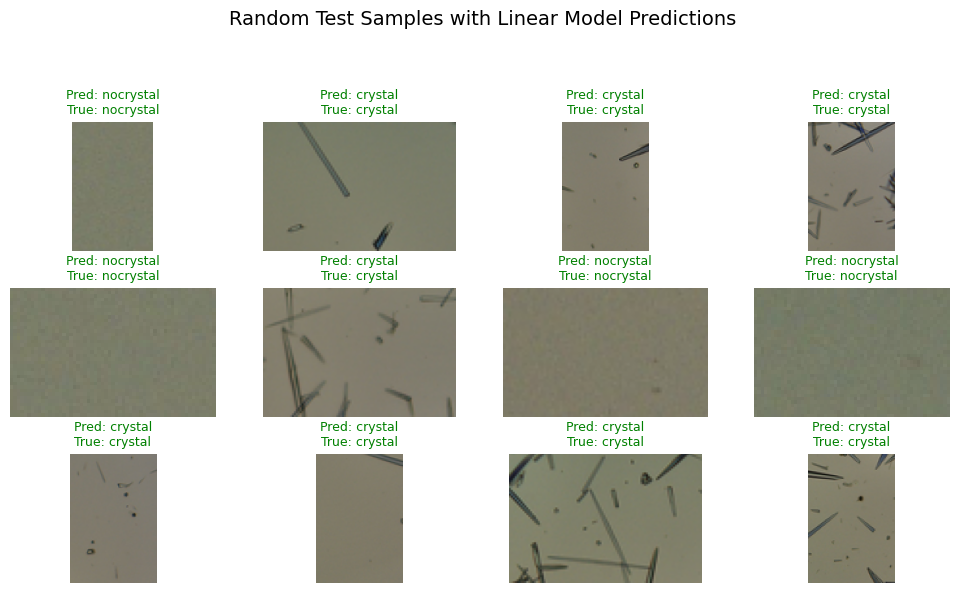

In [16]:
images = [r["pil"] for r in dataset]  # same order as X/y

def show_predictions_linear_idx(clf, X_test, y_test, test_idx, images, class_names, n=12, seed=300):
    import random, numpy as np, matplotlib.pyplot as plt
    random.seed(0)
    y_pred = clf.predict(X_test)
    picks = random.sample(range(len(y_test)), min(n, len(y_test)))

    plt.figure(figsize=(10, 6))
    for i, k in enumerate(picks):
        orig_i = test_idx[k]                  # map back to original dataset index
        img = images[orig_i]                  # already a PIL.Image in RGB
        img_np = np.array(img)

        true = class_names[y_test[k]]
        pred = class_names[y_pred[k]]
        color = "green" if pred == true else "red"

        plt.subplot(3, 4, i + 1)
        plt.imshow(img_np)
        plt.title(f"Pred: {pred}\nTrue: {true}", color=color, fontsize=9)
        plt.axis("off")

    plt.suptitle("Random Test Samples with Linear Model Predictions", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


show_predictions_linear_idx(clf, X_test, y_test, test_idx, images, class_names)

## 4. Image–text Retrieval

We can also use the fact that we have embeddings across two modalities (image and text) to conduct image–text retrieval:

> Given an image, find the best matching prompt.

or

> Given a prompt, find the best matching image.


Note that below you will see the `@` operator there performs matrix multiplication — specifically between the image feature matrix and the transpose of the text feature matrix.

For `img_feats` has shape `[N_img, D]` (one D-dimensional embedding per image)

and `txt_feats` has shape `[N_txt, D]` (one D-dimensional embedding per text prompt)

doing `img_feats @ txt_feats.T` yields a similarity matrix of shape `[N_img, N_txt]`.


Image 100 (crystal): top-3 prompts
  -> an image showing a crystal  score=0.292
  -> a scientific image of a crystal  score=0.277
  -> a photo of a crystal structure  score=0.276


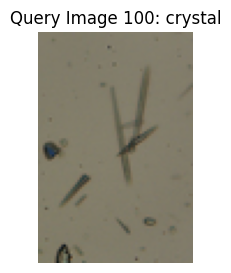


Image 200 (nocrystal): top-3 prompts
  -> a scientific image of nothing present  score=0.249
  -> an image showing nothing present  score=0.245
  -> a photo of nothing present structure  score=0.238


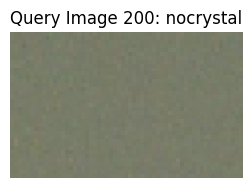

In [17]:
# Given an image, find the best matching text prompts

import matplotlib.pyplot as plt
import numpy as np

if len(image_tensors) > 0:
    sims = (img_feats @ txt_feats.T).detach().cpu().numpy()  # [n_img, n_prompts]
    k = 3  # top-k prompts to show
    img_examples = [100, 200]  # two example images, No 101 and No 201

    for idx_img in img_examples:
        order = np.argsort(-sims[idx_img])[:k]
        print(f"\nImage {idx_img} ({image_labels[idx_img]}): top-{k} prompts")
        for j in order:
            print(f"  -> {prompts[j]}  score={sims[idx_img, j]:.3f}")

        # show the image
        plt.figure(figsize=(3, 3))
        plt.imshow(dataset[idx_img]["pil"])
        plt.title(f"Query Image {idx_img}: {image_labels[idx_img]}")
        plt.axis("off")
        plt.show()


Prompt: 'an image showing a crystal' → top-3 matching images
  -> Image 141: crystal  score=0.313
  -> Image   8: crystal  score=0.308
  -> Image  91: crystal  score=0.305


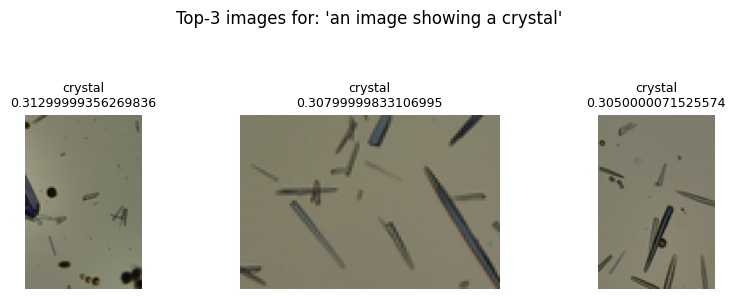


Prompt: 'a photo of a crystal structure' → top-3 matching images
  -> Image 177: crystal  score=0.303
  -> Image   8: crystal  score=0.301
  -> Image 186: crystal  score=0.299


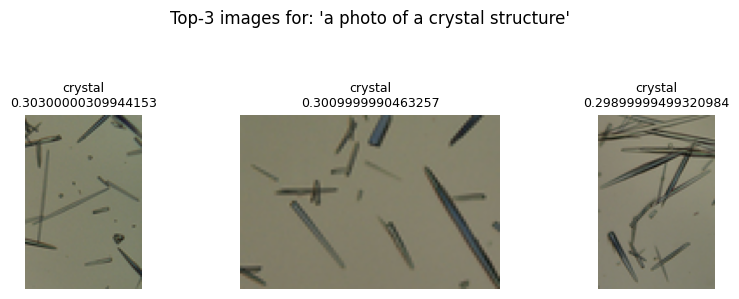

In [18]:
# Given a text prompt, find the best matching images

import matplotlib.pyplot as plt
import numpy as np

if len(image_tensors) > 0:
    sims = (img_feats @ txt_feats.T).detach().cpu().numpy()
    k = 3  # top-k images to show
    text_examples = [0, 1]  # two example prompts

    for idx_text in text_examples:
        order = np.argsort(-sims[:, idx_text])[:k]
        print(f"\nPrompt: '{prompts[idx_text]}' → top-{k} matching images")
        for j in order:
            print(f"  -> Image {j:>3}: {image_labels[j]}  score={sims[j, idx_text]:.3f}")

        # show top-k retrieved images
        plt.figure(figsize=(9, 3))
        for i, j in enumerate(order):
            plt.subplot(1, k, i + 1)
            plt.imshow(dataset[j]["pil"])
            plt.title(f"{image_labels[j]}\n{round(sims[j, idx_text],3)}", fontsize=9)
            plt.axis("off")
        plt.suptitle(f"Top-{k} images for: '{prompts[idx_text]}'", fontsize=12)
        plt.tight_layout(rect=[0, 0, 1, 0.9])
        plt.show()

## 5. Vision Chat with a GPT Model

We now send an image URL together with a question using the **Responses API**.
This part requires a valid API key.

First let's load one image from `wikipedia`.

```python
from IPython.display import Image, display

url = "https://upload.wikimedia.org/wikipedia/commons/8/85/NiPc_MOF_wiki.png"
display(Image(url=url))

from openai import OpenAI

# set your OpenAI API key
OPENAI_API_KEY = "sk-.............."


client = OpenAI(api_key=OPENAI_API_KEY)


# Note: This key will expire after the lecture.
# To run this code later, generate a new API key at:
# https://platform.openai.com/api-keys


# Pick the first image in our small dataset
img_url = "https://upload.wikimedia.org/wikipedia/commons/8/85/NiPc_MOF_wiki.png"
user_question = "Describe this image in 1 sentence."

# Build the input as a list with one user item containing text and image
inp = [
        {
            "role": "user",
            "content": [
                {"type": "input_text", "text": user_question},
                {"type": "input_image", "image_url": img_url} #we put image here after the text
            ]
        }
]

try:
    resp = client.responses.create(model="gpt-4o-mini" , input=inp, temperature=0)
    print(resp.output_text)
except Exception as e:
    print("Vision chat failed:", e)


#Please run the code in Google Colab
```

Alternatively, you can also load image from your local folder.

image.png

```python
import base64


# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


# Path to your image
image_path = "NiPc_MOF_wiki.png"

# Getting the Base64 string
base64_image = encode_image(image_path)


response = client.responses.create(
    model="gpt-4.1",
    input=[
        {
            "role": "user",
            "content": [
                { "type": "input_text", "text": "what's reaction condition in this image?" },
                {
                    "type": "input_image",
                    "image_url": f"data:image/jpeg;base64,{base64_image}",
                },
            ],
        }
    ],
)

#print(response.output_text)
#Please  run this in Google Colab
```

Why this is useful for chemist?

This approach is efficient when dealing with a large body of scientific literature—say, 6,000 papers in a specific field—where manually reviewing each figure or diagram would be impossible.

You can guide vision languge models annotate and classify them according to their content (for example, identifying microscopy images, spectra, or molecular structures). Once labeled, the collection becomes a searchable dataset that allows you to quickly locate and analyze only the figures relevant to a specific research question or data-mining goal. Such automated image annotation and retrieval accelerate insight generation and support large-scale visual pattern discovery in scientific texts.


(See* Digital Discovery*, **2024**, 3, 491–501 for further discussion.)

In [19]:
from IPython.display import Image, display

url = "https://pubs.rsc.org/image/article/2024/dd/d3dd00239j/d3dd00239j-f1_hi-res.gif"
display(Image(url=url, width=800, height=800))

## 6. Glossary


```{glossary}
**CLIP**
    Contrastive Language–Image Pretraining. Learns aligned image and text spaces.

**Contrastive loss**
    Objective that raises similarity of matched pairs and lowers mismatched pairs.

**InfoNCE**
    A popular contrastive objective that treats each batch example as the only positive.

**Projection head**
    The final linear layer that maps encoder features into the shared space.

**Zero-shot**
    Using text prompts alone to classify images without training on task labels.

**Linear probe**
    A linear classifier trained on frozen embeddings.

**Cosine similarity**
    The dot product of two unit vectors.

**Temperature ($\tau$)**
    Scales logits in the contrastive loss. Lower means sharper distributions.

**Retrieval**
    Ranking images for a text query or texts for an image query based on similarity.
```